<a href="https://colab.research.google.com/github/anna-dang/dsc-phase-4-project/blob/main/project_4_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision: X-Ray Classification using Neural Networks

***TODO Describe data source, competition goal, etc. etc.

image sources: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

data source: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

Objective: Build a model that can classify whether a given patient has pneumonia, given a chest x-ray image.

Business problem: ******

Stakeholder: *******



### Import libraries

In [195]:
import os, random, cv2 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras import callbacks, models, layers, optimizers, regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from google.colab import drive

seed = 3
np.random.seed(seed)

### Define functions

In [113]:
def get_num_images(file_path, form='total'):
    """Follows a filepath for this dataset and counts the images per class of NORMAL or PNEUMONIA X-rays.
        Option to return the 'total' elements per folder or a 'tuple' of the count for each type,
        or the 'normed' count (percentage per class of total).

        Output format: (NORMAL, PNEUMONIA) """
    normal = len(os.listdir(file_path + '/NORMAL'))
    pneum = len(os.listdir(file_path + '/PNEUMONIA'))
    tot = normal + pneum
    if form == 'total':
        return tot
    if form == 'normed':
        return tuple(round(i, 3) for i in ((normal/tot), (pneum/tot)))
    if form == 'tuple':
        return (normal, pneum) 

In [ ]:
# TODO build function to evaulate model and print visuals & scoring metrics/conf matrix

### Download data

In [4]:
# Mount the connection to Google Drive
drive.mount('/gdrive',force_remount=True)

Mounted at /gdrive


In [79]:
# Check current directory
os.getcwd()

'/content'

In [6]:
# Define 'local' path as the directory of the virtual machine (where Colab runs)
local_path = '/content'

# Path where data .zip file is stored on Google Drive
zip_path = '/gdrive/MyDrive/kaggle/chest-xray-pneumonia.zip'

# Copy .zip file into local/virtual machine
!cp '{zip_path}' .

In [7]:
# Unzip in local (check pwd)
!unzip -q 'chest-xray-pneumonia.zip'

In [147]:
# Establish file paths for each of the unzipped data folders on the virtual machine
train_path = '/content/chest_xray/train'
test_path = '/content/chest_xray/test'
val_path = '/content/chest_xray/val'

# Count images per path
[get_num_images(path, form='total') for path in [train_path, test_path, val_path]]

[5216, 624, 16]

### Preview raw images

There are two main class types: 'Normal' and 'Pneumonia'. Exploring the data I found that there were two subclasses of pneumonia: bacterial and viral. The model will treat all pnuemonia cases as positive cases and all normal images as negative (0). I visually sinpected the files for incorrect file type or non-xray image. Let's take a look at some of the unprocessed images from each type.

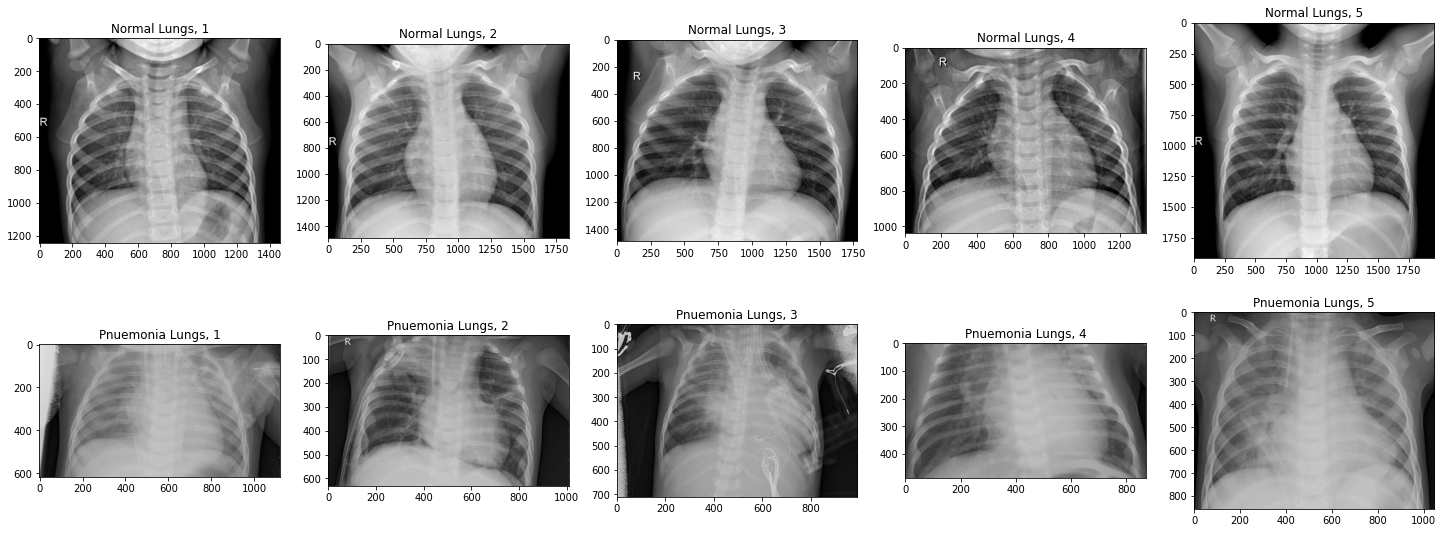

In [203]:
# Randomly select images from both classes to inspect
samples = 5
pneu_imgs = np.random.choice(os.listdir(train_path + '/PNEUMONIA/'), samples, replace = False)
norm_imgs = np.random.choice(os.listdir(train_path + '/NORMAL/'), samples, replace = False)

# Preview unprocessed images sized to fit in single row (keep original aspect ratio)
fig, axes = plt.subplots(nrows=2, ncols=samples, figsize=(25, 25))
for i, img in enumerate(norm_imgs):
    axes[0, i].imshow(cv2.imread(train_path + '/NORMAL/' + img))
    axes[0, i].set_title(f"Normal Lungs, {i + 1}")
for i, img in enumerate(pneu_imgs):   
    axes[1, i].imshow(cv2.imread(train_path + '/PNEUMONIA/' + img))
    axes[1, i].set_title(f"Pnuemonia Lungs, {i + 1}")
plt.subplots_adjust(bottom=0.3, top=0.6, hspace=0)
plt.show()


Without medical traing and just a visual inspection - we see somewhat more opacity in the pneumonia lungs. This could be part of the pattern our model will discover.

We know the X-ray appears grayscale, but is it formated as a grayscale - using a single color channel? How ever many numbers are used to specify the color of each is the number of channels each pixel has, regardless of appearance. A full RGB image (3 color channels) may appear grayscale if all pixel values are equal across channels. Since this affects input shape for the model, we need to investigate

In [49]:
# Check original image pixel dimensions
# Check number of pixel channels (the third dimension) to determine if RGB or grayscale
norm_img.shape, bac_img.shape, vir_img.shape

((1449, 1704, 3), (760, 1152, 3), (768, 1072, 3))

Note there is a variety in image dimensions (not standardized) and there are 3 color channels. Indicating that while these X-rays appear gray, they should be treated as full RGB for the model. Also note the resolution is too large for training resources so the images should be progressively resized until it negatively effects performance.

# Preprocessing



### Format data for Tensorflow/Keras

In [51]:
# Examine the class distribution for each set as items and then percentage split
display([x.split('/')[-1] for x in [train_path, test_path, val_path]])
display([get_num_images(path, form='tuple') for path in [train_path, test_path, val_path]])
[get_num_images(path, form='normed') for path in [train_path, test_path, val_path]]

['train', 'test', 'val']

[(1341, 3875), (234, 390), (8, 8)]

[(0.26, 0.74), (0.38, 0.62), (0.5, 0.5)]

***TODO describe decision to increase of validation size. why split test and not train?? Train has multiple images from same patient. To prevent data leakage to test (of machine having previously seen the image) I chose to split from the test set in hopes its totally blind.

Size of validation set is too small -- will have too high variance?? true?

In [204]:
# Set image size, validation split percentage
img_size = (128, 128)
val_split_size = 0.2

# Instantiate training set image generator with rescale set to reduce RBG values to between 0 and 1
train_datagen = ImageDataGenerator(rescale=(1./255))

# Data is already split into train/test/validation by source, format for Keras
print(" Train:")
train_generator = train_datagen.flow_from_directory(
        train_path, 
        target_size=img_size,
        class_mode='binary',
        batch_size=get_num_images(train_path)) 

# Create a larger validation set than provided by splitting test set further
# Instantiate test generator with test/validation split, label the subsets
test_val_datagen = ImageDataGenerator(rescale=1./255,
                                      validation_split=val_split_size)

print("\n Test:")
test_generator = test_val_datagen.flow_from_directory(
        test_path, 
        target_size=img_size,
        class_mode='binary',
        batch_size=get_num_images(test_path),
        subset='training') 

print("\n Validation:")
val_generator = test_val_datagen.flow_from_directory(
        test_path, 
        target_size=img_size,
        class_mode='binary',
        batch_size=get_num_images(test_path),
        subset='validation') 

 Train:
Found 5216 images belonging to 2 classes.

 Test:
Found 500 images belonging to 2 classes.

 Validation:
Found 124 images belonging to 2 classes.


In [13]:
# Check for class types
train_generator.class_indices 

{'NORMAL': 0, 'PNEUMONIA': 1}

In [205]:
# Create the data sets from the generators, split features (images) from target (labels)
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [15]:
# Check that the data was generated properly
# Expect image size to be (quantity, image size x size, 3) and labels (quantity,)
print("Train:", train_images.shape, train_labels.shape)
print("Test:", test_images.shape, test_labels.shape)
print("Val:", val_images.shape, val_labels.shape)

Train: (5216, 64, 64, 3) (5216,)
Test: (500, 64, 64, 3) (500,)
Val: (124, 64, 64, 3) (124,)


In [16]:
# Reshape into single input vector of pixel values for use in fully connected baseline model
train_img_unrow = train_images.reshape(train_images.shape[0], -1)
test_img_unrow = test_images.reshape(test_images.shape[0], -1)
val_img_unrow = val_images.reshape(val_images.shape[0], -1)

In [141]:
# Check shape for the vectorized image, expecting: (quantity, (pix x pix x 3 rgb))
print([x.shape for x in [train_img_unrow, test_img_unrow, val_img_unrow]])

[(5216, 12288), (500, 12288), (124, 12288)]


### Inspect processed files

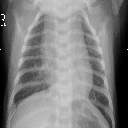

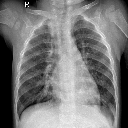

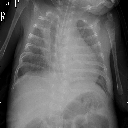

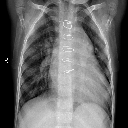

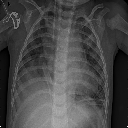

array([1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 0., 1.], dtype=float32)

In [207]:
# Preview some processed images and labels
[display(array_to_img(train_images[x])) for x in np.random.choice(range(0, train_images.shape[0]), 5)]
train_labels[100:125]

### Class Imbalance

Above we saw that the training set is heavily unbalance, favoring pnuemonia images. Time to examine this and correct.




,Quantity,Proportion
Normal,1341,0.257
Pneumonia,3875,0.743


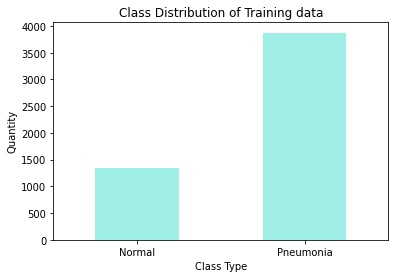

Pneumonia is 2.89 times as represented by the data.


In [143]:
# Display proportion by class for training set
normed = get_num_images(train_path, form='normed')
total = get_num_images(train_path, form='tuple')
total_s = pd.Series(data={'Normal': totals[0], 'Pneumonia': totals[1]}, name= 'Quantity').to_frame()
norm_s = pd.Series(data={'Normal': normed[0], 'Pneumonia': normed[1]}, name= 'Proportion').to_frame()
class_frame = pd.concat([total_s, norm_s], axis=1)
display(class_frame)

# Plot the distribution as a bar graph
total_frame.plot.bar(legend=False, rot=0, color='turquoise', alpha=0.5)
plt.title('Class Distribution of Training data')
plt.xlabel("Class Type")
plt.ylabel("Quantity")
plt.show()

print(f"Pneumonia is represented {round(totals[1]/totals[0], 2)} times as much by the data.")

In [208]:
# Scaling by total/2 helps keep the loss to a similar magnitude (from Keras documentation).
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / totals[0])*(train_images.shape[0])/2.0 
weight_for_1 = (1 / totals[1])*(train_images.shape[0])/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


The training set has unbalanced classes. This could skew the training of the model as it will not be sufficiently trained on what 'normal' lungs look like compared to the pneumonia lungs.

We have 3875 pneumonia and 1341 normal cases. So if our model simply outputs “pneumonia” for every item it sees in the training set, it can easily achieve about 75 percent accuracy.

Strategies:

Upsampling or oversampling increasing the number of “normal” cases by simply repeating them in the training dataset. For even class distribution, we would need to repeat each normal image (randomly) about 2.89 times. We could combine this with data augmentation to make the repeating images differ slighly from the original, in hopes of creating a more robust data set.

Data-oversampling and class weighting are equivalent. Copying the samples of a class 3X is equivalent to assigning a 3X weight to the class. However, the weighting is better from storage and computational point of view since it avoids working with a larger data-set.

Note that based on this equivalency we can mix and match. Increasing the size of a class 6X ≡ increasing the weight 6X ≡ increasing the size 3X and increasing the weight 2X.

If the training process were considering the whole dataset on each gradient update, this oversampling would be basically identical to the class weighting.

But when training the model batch-wise, as you did here, the oversampled data provides a smoother gradient signal: Instead of each positive example being shown in one batch with a large weight, they're shown in many different batches each time with a small weight.

This smoother gradient signal makes it easier to train the model.

Because training is easier on the balanced data, the above training procedure may overfit quickly.

So break up the epochs to give the callbacks.EarlyStopping finer control over when to stop training.

In [ ]:
To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training.

In [ ]:
# TODO correct class imbalance, save as sep variables, test performance of each
# https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html
# from sklearn.utils.class_weight import compute_class_weight
# weights = class_weight('balanced',np.unique(y_train),y_train)
# weights_dict = dict(zip(np.unique(y_train),weights))
# weights_dict 
# ...

# model.fit(X_trian,y_ytrain, class_weight=weights_dict)
# save weights

# weighted_model = make_model()
# weighted_model.load_weights(initial_weights)

# weighted_history = weighted_model.fit(
#     train_features,
#     train_labels,
#     batch_size=BATCH_SIZE,
#     epochs=EPOCHS,
#     callbacks=[early_stopping],
#     validation_data=(val_features, val_labels),
#     # The class weights go here
#     class_weight=class_weight)

### Data Augmentation

"In data augmentation for medical datasets, make sure that you add the ones which make sense and does not change your data in a case that makes it too different from the real world data. when the location of body organs are important"

Note that data augmentation is the process of changing the training samples (e.g. for images, flipping them, changing their luminosity, adding noise, etc.) and adding them back into the set. It is used for enriching the diversity of training samples

# Modeling

***TODO train & val sets

***TODO SAVE MODELS!!!!!!!

The approach I like to take to finding a good model has two stages: first get a model large enough that it can overfit (i.e. focus on training loss) and then regularize it appropriately (give up some training loss to improve the validation loss)

Since there are only two possible labels for the image, we will be using the binary_crossentropy loss

Precision is the number of true positives (TP) over the sum of TP and false positives (FP). It shows what fraction of labeled positives are actually correct.

Recall is the number of TP over the sum of TP and false negatves (FN). It shows what fraction of actual positives are correct.

In [215]:
metrics = ['accuracy', tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')]
## then later
# loss, acc, prec, rec = model.evaluate(test_ds)

### Baseline Model

***TODO descfribe methodology here, fully connected

In [239]:
# Input shape is the pixel size (unrowed) of one image
unrow_input_shape = train_img_unrow[0].shape

# Build model
model = models.Sequential()
model.add(Dense(units=10, activation='relu', input_shape=unrow_input_shape))
# Output is 1 neuron since our binary class labels are combined into one column of 0/1
model.add(Dense(units=1, activation='sigmoid')) 

In [240]:
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=metrics)
model.summary() 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 10)                122890    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 122,901
Trainable params: 122,901
Non-trainable params: 0
_________________________________________________________________


In [238]:
history = model.fit(train_img_unrow,
                    train_labels,
                    epochs=20,
                    batch_size=20,
                    validation_data=(val_img_unrow, val_labels),
                    class_weight=class_weight)

Epoch 1/20
261/261 [==============================] - 2s 8ms/step - loss: 1.6481 - accuracy: 0.5067 - precision: 0.7403 - recall: 0.5199 - val_loss: 1.1613 - val_accuracy: 0.6290 - val_precision: 0.6290 - val_recall: 1.0000
Epoch 2/20
261/261 [==============================] - 1s 5ms/step - loss: 1.4191 - accuracy: 0.5100 - precision: 0.7473 - recall: 0.5143 - val_loss: 0.8911 - val_accuracy: 0.6290 - val_precision: 0.6290 - val_recall: 1.0000
Epoch 3/20
261/261 [==============================] - 1s 5ms/step - loss: 1.3358 - accuracy: 0.5148 - precision: 0.7493 - recall: 0.5213 - val_loss: 1.3354 - val_accuracy: 0.6290 - val_precision: 0.6290 - val_recall: 1.0000
Epoch 4/20
261/261 [==============================] - 1s 5ms/step - loss: 1.2323 - accuracy: 0.5159 - precision: 0.7519 - recall: 0.5200 - val_loss: 0.9757 - val_accuracy: 0.3871 - val_precision: 0.6667 - val_recall: 0.0513
Epoch 5/20
261/261 [==============================] - 1s 5ms/step - loss: 1.0943 - accuracy: 0.5238 - pr

In [241]:
history.history

{'accuracy': [0.5067101120948792,
  0.5099693536758423,
  0.514762282371521,
  0.5159125924110413,
  0.5237730145454407,
  0.5023006200790405,
  0.48408743739128113,
  0.35525307059288025,
  0.3962806761264801,
  0.7183665633201599,
  0.7356211543083191,
  0.5741947889328003,
  0.4261886477470398,
  0.6961272954940796,
  0.6271088719367981,
  0.7429064512252808,
  0.7429064512252808,
  0.7429064512252808,
  0.714532196521759,
  0.6731211543083191],
 'loss': [1.6481412649154663,
  1.41914963722229,
  1.3358232975006104,
  1.2323158979415894,
  1.0942667722702026,
  1.0054339170455933,
  0.74543696641922,
  0.6932055950164795,
  0.6931807994842529,
  0.6932053565979004,
  0.6932060718536377,
  0.6932097673416138,
  0.693175196647644,
  0.6932071447372437,
  0.6931918263435364,
  0.6932231187820435,
  0.6932198405265808,
  0.6932257413864136,
  0.6932153701782227,
  0.6931926608085632],
 'precision': [0.7402737736701965,
  0.7472816109657288,
  0.7492581605911255,
  0.7518656849861145,
  

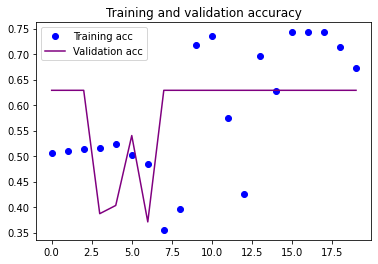

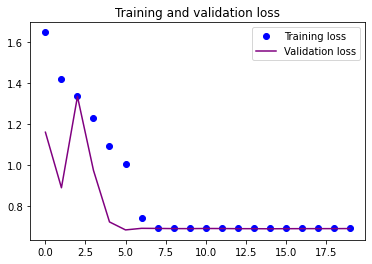

In [242]:
# TODO visualize model performance curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', color='purple', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', color='purple', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [243]:
# TODO analysis 
results_train = model.evaluate(train_img_unrow, train_labels)
print("Train score:", results_train)
results_test = model.evaluate(test_img_unrow, test_labels)
print("Test score:", results_test)

163/163 [==============================] - 0s 2ms/step - loss: 0.7067 - accuracy: 0.4362 - precision: 0.7398 - recall: 0.3769
Train score: [0.7067235112190247, 0.4361579716205597, 0.7398212552070618, 0.3769289255142212]
16/16 [==============================] - 0s 6ms/step - loss: 0.6998 - accuracy: 0.4760 - precision: 0.6453 - recall: 0.3558
Test score: [0.6998158693313599, 0.47600001096725464, 0.645348846912384, 0.35576921701431274]


Dense baseline analysis: Shows how various metrics can give drastically different scores. Precision scoring is highest but shows significant overfittitng. The other metrics are worse than guessing (50/50) but within a point or two. So it's terribly unpredictive model but not horribly overfit.

### Convolutional Neural Network (CNN)

***TODO explain methodology per iteration


#### Slow Iterations:
builds from simple to complex and at every step of the way we make concrete hypotheses about what will happen and then either validate them with an experiment or investigate until we find some issue. What we try to prevent very hard is the introduction of a lot of “unverified” complexity at once, which is bound to introduce bugs/misconfigurations

complexify only one at a time. If you have multiple signals to plug into your classifier I would advise that you plug them in one by one and every time ensure that you get a performance boost you’d expect. Don’t throw the kitchen sink at your model at the start. There are other ways of building up complexity - e.g. you can try to plug in smaller images first and make them bigger later, etc.

Build up a model that is over fit, then work on validation loss reduction. exploring a wide model space for architectures that achieve low validation loss.

In [ ]:
# # To save models
# model_path = 'filepath'+'name.hd5'
# model.save(cnn_path)

# # Load model
# model_loaded = load_model(model_path)

#### Iteration 1

In [ ]:
# # since using *image* as input
# model.fit_generator()

### Iteration : Image Augmentation



### Iteration : Class Imbalance Corrected

### Iteration : Regularize

Ideally, we are now at a place where we have a large model that is fitting at least the training set. Now it is time to regularize it and gain some validation accuracy by giving up some of the training accuracy. Some tips & tricks:

#### Iteration : Transfer Data / Pre-Train

# Evaluation

***TODO which metric to use and about how best to cross-validate your 
results on TEST SET

which type of wrong answers are most concerning

High bias favors train perform, high variance favors val perform

False negatives and false positives are samples that were incorrectly classified

True negatives and true positives are samples that were correctly classified

Accuracy is the percentage of examples correctly classified > 
Precision is the percentage of predicted positives that were correctly classified > 
Recall is the percentage of actual positives that were correctly classified > 
AUC refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the pro


In [ ]:
# TODO use TEST set for unbiased eval of model

In [ ]:
# TODO calculate the AUC-ROC to measure your model's discrimination.

In [ ]:
# TODO visualize intermediate layers
# TODO visualize heatmap of image patterns identified (HOW is model working?)

In [ ]:
# Save final model

# Conclusion

***TODO summarize findings, give 3 reccomendations related to business problem and model performance


Possible reccomendations: disuss lowest image quality hat delivered results (can reduce from jump to minimize storage), recs on HOW to use model?

Be sure notebook answers these questions with clarity:

•	"How did you pick the question(s) that you did?"

•	"Why are these questions important from a business perspective?"

•	"How did you decide on the data cleaning options you performed?"

•	"Why did you choose a given method or library?"

•	"Why did you select these visualizations and what did you learn from each of them?"

•	"Why did you pick those features as predictors?"

•	"How would you interpret the results?"

•	"How confident are you in the predictive quality of the results?"

•	"What are some of the things that could cause the results to be wrong?"
